In [1]:
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np

import torch
from torch.utils.data import DataLoader
import torchaudio

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from loguru import logger

## Configurations

In [2]:
from hydra import initialize, compose

with initialize(config_path="./"):
    cfg = compose('config.yaml')

torch.Size([46797]) 16000
tensor([-0.1199, -0.1207, -0.1195, -0.1203, -0.1203, -0.1191, -0.1203, -0.1199,
        -0.1215, -0.1211, -0.1195, -0.1199, -0.1203, -0.1203, -0.1191, -0.1182,
        -0.1182, -0.1182, -0.1182, -0.1182])
0: h# 0.190625
1: sh 0.2849375
2: ix 0.3576875
3: hv 0.415125
4: eh 0.54825
5: dcl 0.574375
6: jh 0.6460625
7: ih 0.7198125
8: dcl 0.78125
9: d 0.79
10: ah 0.919625
11: kcl 0.991875
12: k 1.020875
13: s 1.1305
14: ux 1.2760625
15: q 1.3249375
16: en 1.41
17: gcl 1.4325
18: g 1.4544375
19: r 1.5143125
20: ix 1.597875
21: s 1.69725
22: ix 1.754
23: w 1.85375
24: ao 1.9824375
25: sh 2.085
26: epi 2.109625
27: w 2.1696875
28: ao 2.255
29: dx 2.270375
30: axr 2.34725
31: ao 2.4725625
32: l 2.5195625
33: y 2.6286875
34: ih 2.7174375
35: axr 2.786625


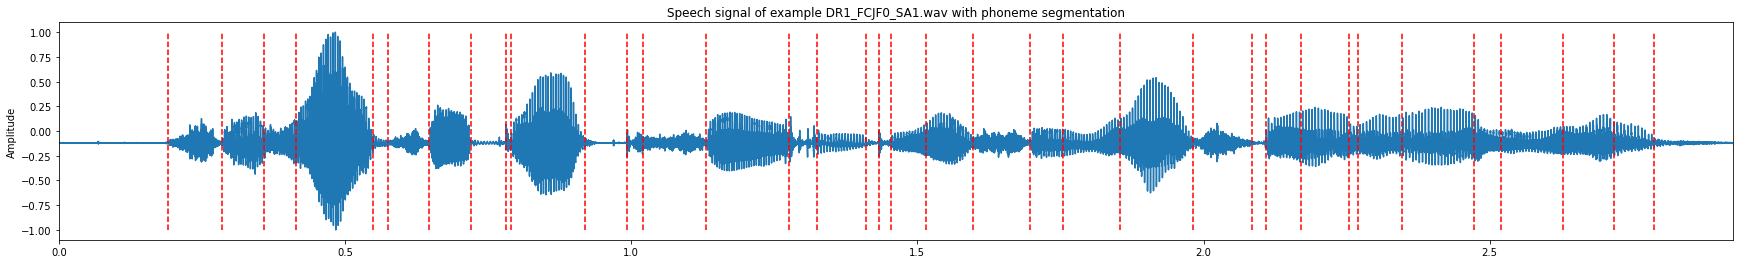

In [3]:
# Load data
signalData, samplingFrequency = torchaudio.load(cfg.wav_path, normalize=False)
signalData = signalData[0]

# Normalize data
signalData = 2 * (signalData - torch.min(signalData)) / (torch.max(signalData) - torch.min(signalData)) - 1 

print(signalData.shape, samplingFrequency)
print(signalData[:20])

# Read phoneme segmentation and annotation
with open(cfg.phn_path, 'r') as fp:
    lines = fp.readlines()
    lines = list(map(lambda line: line.split(" "), lines))

times = list(map(lambda line: int(line[1]), lines))[:-1]
labels = list(map(lambda line: line[2].strip(), lines))[:-1]

for i, (label, time) in enumerate(zip(labels, times)):
    print(f'{i}:', label, time / samplingFrequency)

x = np.array(list(range(len(signalData)))) / samplingFrequency
x_end = len(signalData) / samplingFrequency

plt.figure(figsize=(30, 4))
plt.title(f'Speech signal of example {cfg.file_name}.wav with phoneme segmentation')
plt.plot(x, signalData)
plt.xlim((0.0, x_end))
plt.ylabel('Amplitude')
for time in times:
    plt.vlines(time / samplingFrequency, -1, 1, colors = "r", linestyles = "dashed")
plt.show()

## Data Processing

In [4]:
from data_processing import TimitDataset, print_list, collate_fn_pad

In [5]:
def test_dataloader(cfg):
    if_dev_run = cfg.dev_run
    cfg.dev_run = True
    # spect, _, _, _, phoneme_labels, _ = TimitDataset(cfg.dataset_path, cfg).process_file(cfg.wav_path)
    # print(type(spect))
    # print(spect.shape, phoneme_labels.shape)
    # print(spect[:5])
    # # print(phoneme_labels.argmax(1))
    # print_list(phoneme_labels.argmax(1), 25)

    TimitDataset(os.path.join(cfg.dataset_path, 'train'), cfg)

    # print(cfg.ckpt_path)
    cfg.dev_run = if_dev_run

test_dataloader(cfg)

2022-05-17 15:40:57.593 | INFO     | data_processing:__init__:77 - Loading 50 files into cache ...
100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


## Model Definition

In [5]:
import torch
from torch.nn import Module, Sequential, PReLU, Linear, Conv2d


class Segmentor(Module):
    def __init__(self, hparams):
        super(Segmentor, self).__init__()
        self.hparams = hparams

        self.encoder = Sequential(
            Conv2d(1, hparams.z_dim, kernel_size=(hparams.k_1_h, hparams.k_1_w)),
            PReLU(),
            Conv2d(hparams.z_dim, hparams.z_dim * 2, kernel_size=(hparams.k_2_h, hparams.k_2_w)),
            PReLU()
        )

        self.classifier = Sequential(
            Linear(hparams.fc_input, hparams.fc_hidden_1),
            PReLU(),
            Linear(hparams.fc_hidden_1, hparams.fc_hidden_2),
            PReLU(),
            Linear(hparams.fc_hidden_2, hparams.n_classes),
        )

    def forward(self, spect):
        encoded = self.encoder(spect)
        encoded = torch.flatten(encoded, 1)

        cls_out = self.classifier(encoded)

        return cls_out

In [6]:
def test_model(cfg):
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

    conv1 = Conv2d(1, cfg.z_dim, kernel_size=(cfg.k_1_h, cfg.k_1_w))
    conv2 = Conv2d(cfg.z_dim, cfg.z_dim * 2, kernel_size= (cfg.k_2_h, cfg.k_2_w))
    input_data = torch.randn(246, 1, 13, 9)
    conv1_output = conv1(input_data)
    print(conv1_output.shape)
    conv2_output = conv2(conv1_output)
    print(conv2_output.shape)
    print(32 * 7 * 7)

## Training & Testing

In [15]:
def train_loop(epoch_i, dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    total_loss = 0
    with tqdm(total=size, desc=f'epoch {epoch_i}') as t:
        for i, (X, _, _, _, y_class, _) in enumerate(dataloader):
            output = model(X)
            loss = loss_fn(output, y_class)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            t.set_postfix_str(f'loss={total_loss / (i + 1):>7.3f}')
            t.update()

    return total_loss / size

def get_img_from_logits(logits, cmap, alpha):
    img = np.ones((logits.shape[1], logits.shape[0], 4))
    for i, log in enumerate(logits):
        img[:, i, :3] = np.transpose(np.array([log]).transpose(1, 0) * cmap, (1, 0)).transpose(1, 0)
        img[:, i, -1] = [alpha] * np.shape(logits)[1]
    return img

def print_val(file_name, targets, labels, preds, logits):
    print("Wav File:", file_name, f"Accuracy: {sum([x == y for x, y in zip(targets, preds)]) / len(targets) * 100:2.2f}%")
    print("Ground Truth:")
    print_list(targets)
    print("Prediction:")
    print_list(preds)

    logits_img = get_img_from_logits(logits, [0, 1, 0], 1)
    gt_img = get_img_from_logits(labels, [0, 1, 0], 1)

    figs, axes = plt.subplots(2, sharex=True, figsize=(30, 4))

    axes[0].set_title('Ground Truth')
    axes[0].imshow(gt_img)
    axes[1].set_title('Prediction')
    axes[1].imshow(logits_img)
    plt.show()

def validate(dataloader, model, loss_fn):
    size = len(dataloader)
    val_loss = 0
    pred_list, logits_list, target_list, label_list, wav_list = [], [], [], [], []

    with torch.no_grad():
        for X, _, _, _, y_class, wav_file in dataloader:
            output = model(X)
            val_loss += loss_fn(output, y_class).item()
            pred, gt = output.argmax(1), y_class.argmax(1)
            logits_list.append(torch.sigmoid(output.cpu()).numpy())
            label_list.append(y_class.cpu().numpy())
            pred_list.append(pred.tolist())
            target_list.append(gt.tolist())
            wav_list.append(wav_file)

    val_loss /= size
    val_acc, val_pre, val_recall, val_f1 = report_func(target_list, pred_list)

    logger.info(f"Val Result: Avg loss: {val_loss:>7.3f} Accuracy: {(100*val_acc):>4.1f}% Precision: {(100*val_pre):>4.1f}% Recall: {val_recall:>5.3f} F1: {val_f1:>5.3f}")

    idx = np.random.randint(0, size)
    print_val(wav_list[idx].rsplit('\\', 1)[1], target_list[idx], label_list[idx], pred_list[idx], logits_list[idx])

    return val_loss, val_acc, val_pre, val_recall, val_f1

def report_func(pred, target):
    batch_size = len(pred)
    acc, pre, recall, f1 = 0, 0, 0, 0

    for i in range(batch_size):
        acc += accuracy_score(target[i], pred[i])
        pre += precision_score(target[i], pred[i], average='micro')
        recall += recall_score(target[i], pred[i], zero_division=0, average='micro')
        f1 += f1_score(target[i], pred[i], zero_division=0, average='micro')

    acc /= batch_size
    pre /= batch_size
    recall /= batch_size
    f1  /= batch_size
    return acc, pre, recall, f1

In [7]:
torch.cuda.set_device(cfg.device_id)

if not os.path.exists(cfg.output_path):
    os.makedirs(cfg.output_path, exist_ok=True)

### Train

#### Load train Data

In [9]:
train_dataset, val_dataset = TimitDataset.get_train_dataset(cfg.dataset_path, cfg)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_pad, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn_pad)

2022-05-17 18:39:40.121 | INFO     | data_processing:__init__:77 - Loading 4620 files into cache ...
100%|██████████| 4620/4620 [11:23<00:00,  6.76it/s]


#### Run train loop

2022-05-17 18:57:37.819 | INFO     | __main__:<module>:9 - Model initiated.
2022-05-17 18:57:37.819 | INFO     | __main__:<module>:11 - Training started.


----------------------------


epoch 0: 100%|██████████| 4158/4158 [00:15<00:00, 265.62it/s, loss=  1.805]
2022-05-17 18:57:54.371 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.611 Accuracy: 59.6% Precision: 59.6% Recall: 0.596 F1: 0.596


Wav File: DR4_MFWK0_SX349.WAV Accuracy: 52.71%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
17, 17, 17, 17,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 36, 36, 36, 36, 36, 36, 36, 
36, 10, 10,  7,  7,  7,  7, 30, 30, 30, 30, 30, 30, 30, 30, 30, 11, 11, 11, 11, 11, 16, 16, 16, 16, 
16, 16, 16, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7, 37, 37, 37, 37, 37, 37, 32, 32, 
31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10,  9,  9,  9, 11, 11, 11, 11, 11, 11, 11, 
11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 22, 
22, 22, 22, 22, 22, 28, 28, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 18, 
18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 11, 11, 11, 11, 11, 11, 26, 26, 26, 
26, 26, 26, 26, 27, 27, 27, 27

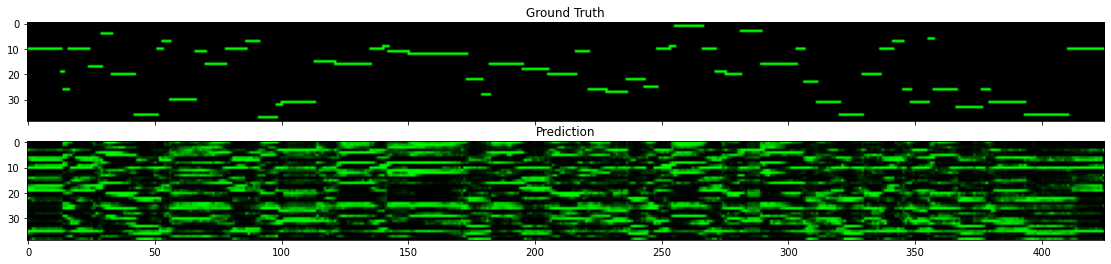

epoch 1: 100%|██████████| 4158/4158 [00:15<00:00, 273.01it/s, loss=  1.562]
2022-05-17 18:58:10.672 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.545 Accuracy: 60.6% Precision: 60.6% Recall: 0.606 F1: 0.606


Wav File: DR7_MHXL0_SX332.WAV Accuracy: 56.86%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 35, 35, 35,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 17, 17, 17, 17, 17, 11, 11, 11, 11, 11,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17, 17,  4,  4, 
 4,  4,  4,  4,  4, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8, 16, 16, 16, 16, 16, 16, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 
25, 25, 25, 25, 25, 25, 25, 25, 25, 31, 31, 31, 31, 31, 31, 31, 10, 10, 10, 34,  0,  0,  0,  0,  0, 
 0,  0,  0,  0,  0, 32, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 
28, 26, 26, 26, 26, 26, 26, 26

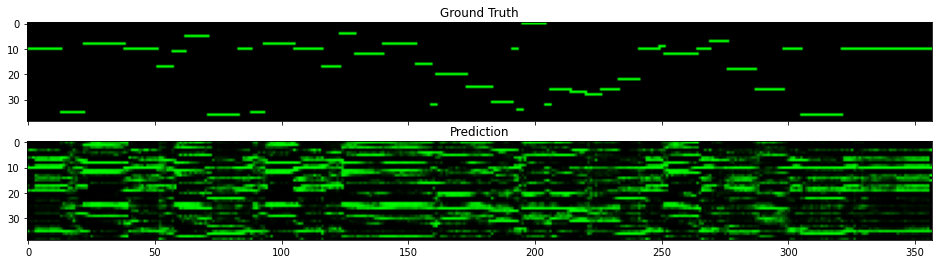

epoch 2: 100%|██████████| 4158/4158 [00:15<00:00, 270.79it/s, loss=  1.480]
2022-05-17 18:58:27.107 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.528 Accuracy: 61.6% Precision: 61.6% Recall: 0.616 F1: 0.616


Wav File: DR1_FETB0_SX428.WAV Accuracy: 61.92%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 
10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  4,  4,  4,  4,  4,  4,  4,  4, 29, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 10, 10, 10, 10, 10, 38, 38, 38, 38, 38, 38, 38, 
38, 38, 38, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 11, 11, 11, 11, 11,  0,  0, 
 0,  0,  0,  0,  0,  0,  0, 31, 31, 31, 31, 31, 31, 31, 33, 33, 33, 33, 33, 10, 10, 10, 10,  3,  3, 
 3,  3,  3,  3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9, 25, 25, 
25, 25, 32,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7, 
 7,  7,  7, 13, 13, 13, 26, 26, 26, 26, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7, 36, 36, 36, 
36, 36, 36, 10, 10, 10, 10, 35

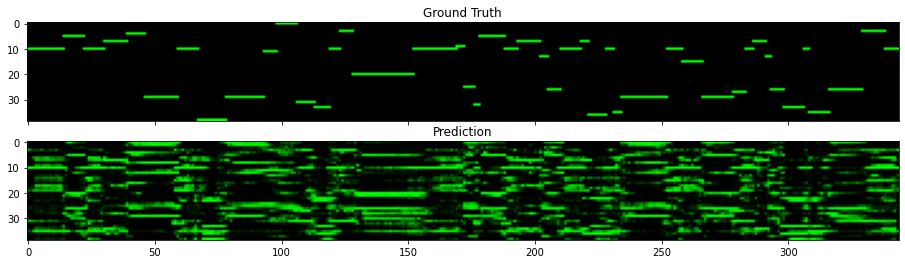

epoch 3: 100%|██████████| 4158/4158 [00:15<00:00, 264.60it/s, loss=  1.420]
2022-05-17 18:58:43.914 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.495 Accuracy: 61.5% Precision: 61.5% Recall: 0.615 F1: 0.615


Wav File: DR7_MTMN0_SX164.WAV Accuracy: 64.23%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7, 
 7,  7,  7,  7,  7, 21, 21, 21, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 
20, 20, 20, 20,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 36, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 26, 26, 26, 32, 32, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 26, 26, 26, 31, 31, 31, 31, 31, 31,  3,  3,  3,  3,  3,  3, 
 3, 20, 20, 20, 20, 20, 20, 20, 20, 32, 32, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  4, 
 4,  4, 26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 20, 20, 20, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,  0,  0,  0,  0,  0, 
 0,  0, 11, 11, 11, 11, 11, 10

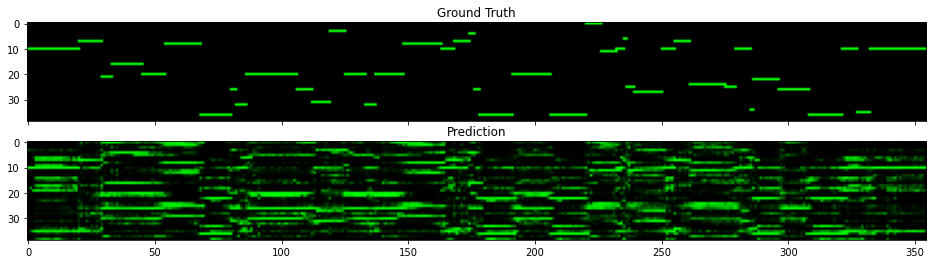

epoch 4: 100%|██████████| 4158/4158 [00:14<00:00, 285.81it/s, loss=  1.373]
2022-05-17 18:58:59.545 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.492 Accuracy: 62.2% Precision: 62.2% Recall: 0.622 F1: 0.622


Wav File: DR7_MREM0_SX151.WAV Accuracy: 50.84%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 19, 26, 26, 10, 10, 10, 10, 10, 10, 10, 17, 17, 
17, 17, 17, 17,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 
20, 26, 26, 26, 26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 17, 17, 
20, 20, 20, 20, 20, 20, 20, 20, 20, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 16, 16, 16, 16, 
16, 16, 16, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 17,  4,  4,  4,  4, 26, 26, 26, 22, 22, 22, 
22, 22, 22, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0, 31, 31, 31, 26, 26, 26, 26, 26, 26, 26, 32, 32, 
32, 32, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,  3,  3,  3,  3,  3,  3,  3,  3,  3, 10, 
10, 10,  9,  9,  9, 26, 26, 26, 26, 26, 26, 10, 10, 10, 10, 10, 10, 34, 34, 34, 21, 21, 21, 21, 21, 
30, 30, 30, 30, 30, 30, 30, 25, 25, 25, 25, 25, 25, 25, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 
 4,  4,  4,  4,  4, 26, 26, 26

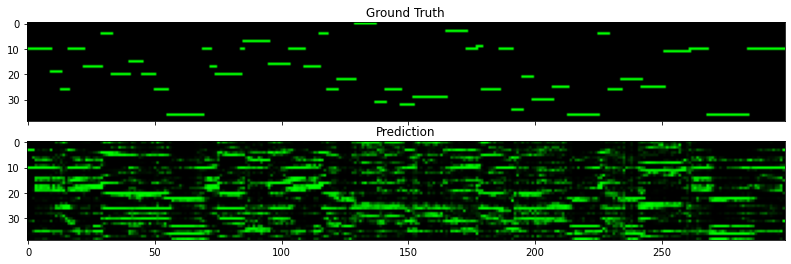

epoch 5: 100%|██████████| 4158/4158 [00:14<00:00, 285.79it/s, loss=  1.332]
2022-05-17 18:59:15.204 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.498 Accuracy: 61.7% Precision: 61.7% Recall: 0.617 F1: 0.617


Wav File: DR4_FKDW0_SA2.WAV Accuracy: 64.10%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
24, 24, 31, 31, 35, 35, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 
36, 36, 36, 36, 10, 10, 10, 10,  3,  3,  3,  3,  3, 20, 20, 20, 20, 20, 20, 20, 20, 32, 32, 26, 26, 
26, 26, 26, 26, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  0,  4, 
 4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 35, 35, 35, 35, 35, 26, 26, 26, 26, 26, 26, 31, 
31, 31, 31, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 11, 11, 11, 11, 11, 11, 
11, 11, 20, 20, 20, 20, 20, 20,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 29, 29, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 34, 11, 11, 11, 11, 11, 11, 
11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 
19, 29, 29, 29, 29, 29, 29, 29, 

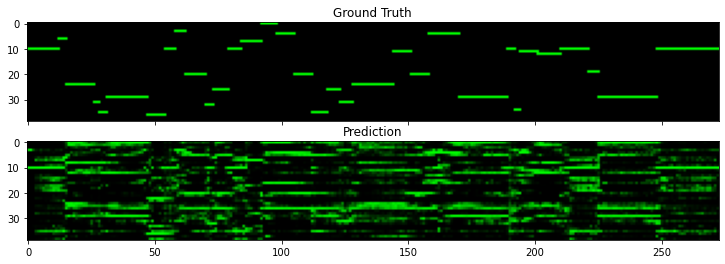

epoch 6: 100%|██████████| 4158/4158 [00:15<00:00, 270.37it/s, loss=  1.293]
2022-05-17 18:59:31.669 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.531 Accuracy: 61.6% Precision: 61.6% Recall: 0.616 F1: 0.616


Wav File: DR2_MMDS0_SI1973.WAV Accuracy: 59.12%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 25, 25, 25, 35, 35, 35,  0,  0, 
 0,  0, 31, 26, 26, 26,  3,  3,  3,  3,  3,  3,  3, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 
10, 10, 10,  6,  6,  6, 26, 26, 26, 26, 26, 26, 10, 10, 10, 10, 10, 10, 31, 31, 31,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 35, 35, 35, 35, 35, 35, 15, 15, 15, 15, 15, 15, 15, 15, 26, 
26, 26, 26, 26, 26, 26, 26, 26, 26,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 10, 35, 35, 35, 35,  0, 29, 29, 29, 29, 
29,  0, 26, 26, 26, 29, 26, 26,  3,  3,  3,  3,  3, 26, 20, 20, 20, 20, 20, 20, 20, 10, 10, 10, 10, 
10, 10, 10, 10,  6,  6, 26, 26, 26, 20, 20, 26, 26, 10, 10, 10, 10, 10, 10, 31, 31, 31, 24, 24, 29, 
 1,  1,  8,  1, 29,  8, 29, 29, 29, 29, 29, 29, 32,  2, 35, 35, 26, 1

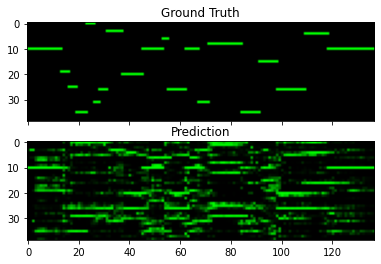

epoch 7: 100%|██████████| 4158/4158 [00:15<00:00, 269.25it/s, loss=  1.257]
2022-05-17 18:59:48.167 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.517 Accuracy: 62.0% Precision: 62.0% Recall: 0.620 F1: 0.620


Wav File: DR1_FTBR0_SI1402.WAV Accuracy: 48.44%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 20, 20, 20, 20, 20, 10, 10, 10, 
10, 10,  6,  6, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31,  8,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8, 16, 16, 16, 16, 16, 16,  4,  4,  4,  4,  4,  4,  4, 12, 12, 12, 12, 12, 
12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 15, 15, 15, 15, 15, 26, 26, 26, 26, 
26, 26, 26, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5, 
 5,  5,  5,  5,  5,  5, 33, 33, 33, 33, 33, 33, 33, 33, 33, 11, 11, 11, 11, 11, 11, 11, 35, 35, 35, 
35, 35, 35, 35, 35, 26, 26, 26, 26, 26,  3,  3,  3,  3,  3,  3, 25, 25, 25, 25, 25, 25, 10, 10, 10, 
10, 10, 10, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 22, 22, 22, 22, 22, 22, 22, 22, 
10, 10, 10, 10, 10, 10,  9,  9, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  3,  3,  3,  3,  3,  3,  3, 
20, 20, 20, 20, 20, 20, 20, 2

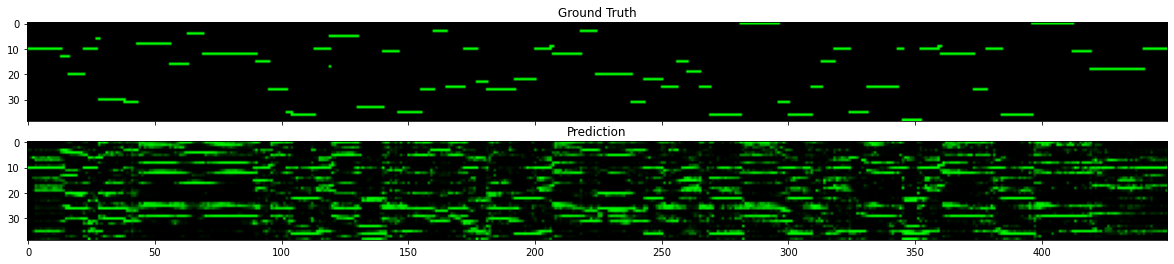

epoch 8: 100%|██████████| 4158/4158 [00:15<00:00, 265.06it/s, loss=  1.221]
2022-05-17 19:00:04.968 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.564 Accuracy: 61.2% Precision: 61.2% Recall: 0.612 F1: 0.612


Wav File: DR3_MDJM0_SX195.WAV Accuracy: 65.15%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 26, 26, 26, 10, 10, 10, 10, 10, 21, 
21, 21, 21, 21, 30, 30, 30, 30, 30, 30, 30, 25, 25, 25, 25, 25, 11, 11, 11, 11, 11, 11, 11, 11, 11, 
 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 
35, 35, 35, 35, 35, 35, 35, 35, 35, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 
10, 10,  7,  7,  7, 36, 36, 36, 36, 36, 36, 36, 36, 25, 25, 25, 25, 25, 15, 15, 15, 15, 15, 15, 15, 
15, 15, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 
11, 25, 25, 25, 25, 25, 31, 31, 10, 10, 10, 10, 10, 10, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 
36, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 26, 20, 20, 26, 26, 10, 10, 10, 21, 21, 
23, 21, 21, 21, 30, 26, 30

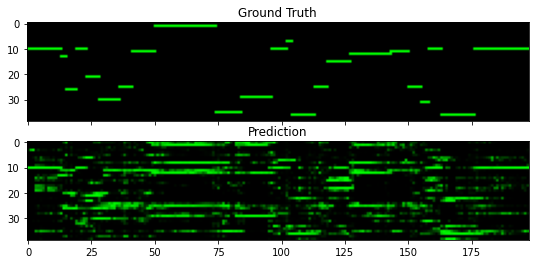

epoch 9: 100%|██████████| 4158/4158 [00:14<00:00, 277.22it/s, loss=  1.189]
2022-05-17 19:00:21.033 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.573 Accuracy: 61.5% Precision: 61.5% Recall: 0.615 F1: 0.615


Wav File: DR4_FALR0_SI1955.WAV Accuracy: 60.94%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 
12, 12, 12, 12, 12, 10, 10, 10, 10,  7,  7,  7,  7,  7, 20, 20, 20, 31, 31, 31, 31, 31, 25, 25, 25, 
25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 13, 
13, 25, 25, 11, 11, 11, 11, 11, 11,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 11, 11, 11, 
11, 11, 11, 10, 10, 10, 10,  9,  9, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25, 25, 25, 25, 
25, 25, 25, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17,  8,  8,  8,  8,  8,  8, 31, 31, 31, 31, 10, 
10, 10, 10, 35, 35, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 17, 17, 12, 12, 12, 12, 12, 12, 12, 12, 36, 36, 36, 36, 36, 36, 36, 36, 
36, 36, 36, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 31, 31, 31, 31, 10, 10, 10,  6,  1,  1,  1,  1, 
 1,  1,  1,  1,  1,  1,  1,  

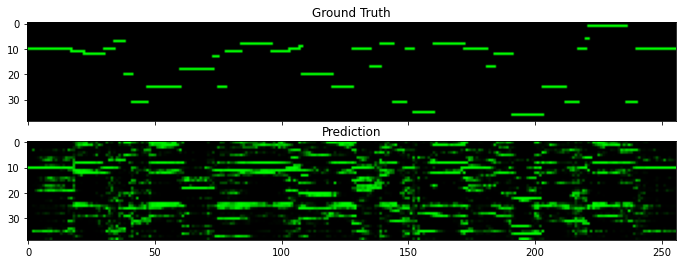

epoch 10: 100%|██████████| 4158/4158 [00:14<00:00, 279.94it/s, loss=  1.160]
2022-05-17 19:00:36.943 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.597 Accuracy: 61.1% Precision: 61.1% Recall: 0.611 F1: 0.611


Wav File: DR3_MADC0_SI1367.WAV Accuracy: 59.65%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 26, 26, 26, 26, 26, 10, 10, 
10, 10, 10, 10, 10,  9,  9,  9, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 32, 32, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20,  3,  3,  3,  3,  3,  3,  3,  3,  3, 
 3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 32, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 
26, 26, 31, 31, 31, 31, 31, 31, 31, 10, 10, 10, 10, 10, 10, 10, 34, 34,  4,  4,  4,  4,  4,  4,  4, 
 4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 32, 32, 32, 20, 20, 20, 20, 20, 10, 10, 10, 
10, 10,  7,  7,  7,  7,  7,  7,  7,  7, 13, 13, 13, 26, 26, 26, 26, 26, 15, 15, 15, 15, 15, 15, 15, 
15, 25, 11, 11, 11, 11, 11, 11, 11, 26, 26, 26, 26, 26, 31, 31, 31, 31, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 13, 13, 26, 26, 22, 22, 22, 22, 22, 22, 22, 
22, 22, 21, 21, 21, 21, 21, 2

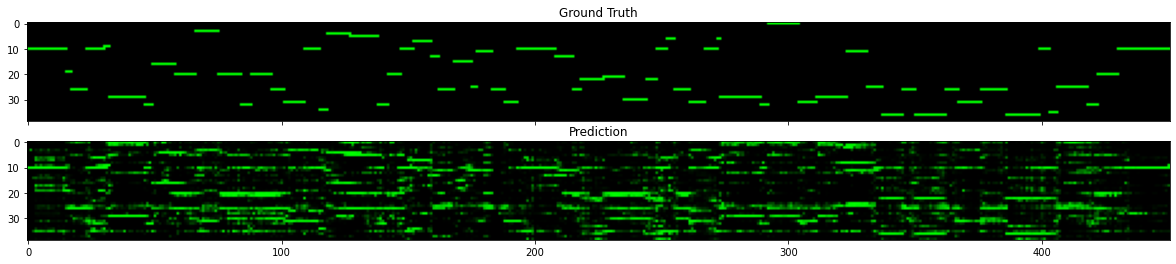

epoch 11: 100%|██████████| 4158/4158 [00:15<00:00, 266.79it/s, loss=  1.130]
2022-05-17 19:00:53.686 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.642 Accuracy: 60.7% Precision: 60.7% Recall: 0.607 F1: 0.607


Wav File: DR3_MJKR0_SX391.WAV Accuracy: 54.17%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
35, 35, 35, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 
11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10,  7, 
 7,  7,  7,  7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,  8,  8,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 
28, 28, 28, 28, 28, 28, 28, 28, 28, 28,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 
 8, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,  1,  1, 
 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 16, 16, 16, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 
36, 36, 10, 10, 10, 10, 10, 10

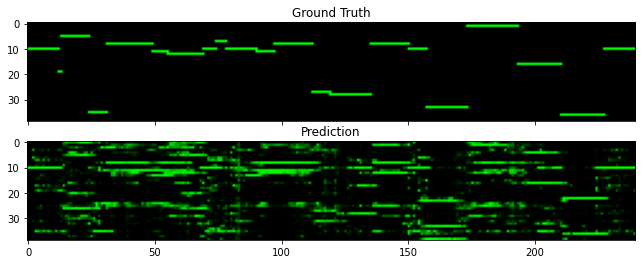

epoch 12: 100%|██████████| 4158/4158 [00:15<00:00, 276.61it/s, loss=  1.103]
2022-05-17 19:01:09.749 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.684 Accuracy: 61.0% Precision: 61.0% Recall: 0.610 F1: 0.610


Wav File: DR7_FJSK0_SA1.WAV Accuracy: 75.14%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 
33, 20, 20, 20, 20, 20, 20, 20, 20, 20, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 
29, 29, 10, 10, 10, 10, 10,  6,  6,  6,  6, 21, 21, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 
10,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4,  4,  4, 10, 10, 10, 
10,  7,  7,  7,  7, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 30, 30, 30, 30, 30, 30, 30, 30, 30, 
30, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10, 10, 10, 35, 35, 35, 35, 35, 35, 26, 26, 26, 26, 31, 31, 
31, 31, 31, 31, 31, 10, 10, 10, 10, 10, 34, 34, 34,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 
20, 20, 20, 20, 20, 20, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 
 8,  4,  4,  4,  4,  4, 33, 33, 

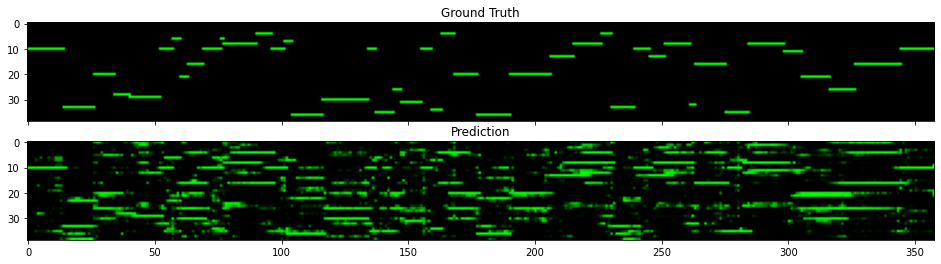

epoch 13: 100%|██████████| 4158/4158 [00:15<00:00, 276.54it/s, loss=  1.080]
2022-05-17 19:01:25.851 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.681 Accuracy: 60.9% Precision: 60.9% Recall: 0.609 F1: 0.609


Wav File: DR3_MADC0_SI1367.WAV Accuracy: 58.98%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 26, 26, 26, 26, 26, 10, 10, 
10, 10, 10, 10, 10,  9,  9,  9, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 32, 32, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20, 20,  3,  3,  3,  3,  3,  3,  3,  3,  3, 
 3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 32, 32, 32, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 
26, 26, 31, 31, 31, 31, 31, 31, 31, 10, 10, 10, 10, 10, 10, 10, 34, 34,  4,  4,  4,  4,  4,  4,  4, 
 4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 32, 32, 32, 20, 20, 20, 20, 20, 10, 10, 10, 
10, 10,  7,  7,  7,  7,  7,  7,  7,  7, 13, 13, 13, 26, 26, 26, 26, 26, 15, 15, 15, 15, 15, 15, 15, 
15, 25, 11, 11, 11, 11, 11, 11, 11, 26, 26, 26, 26, 26, 31, 31, 31, 31, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 13, 13, 26, 26, 22, 22, 22, 22, 22, 22, 22, 
22, 22, 21, 21, 21, 21, 21, 2

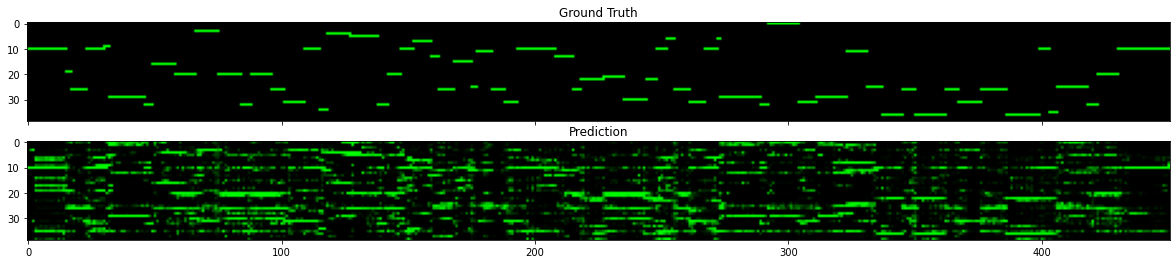

epoch 14: 100%|██████████| 4158/4158 [00:15<00:00, 271.52it/s, loss=  1.056]
2022-05-17 19:01:42.252 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.732 Accuracy: 59.8% Precision: 59.8% Recall: 0.598 F1: 0.598


Wav File: DR8_MEJS0_SA2.WAV Accuracy: 68.18%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6, 24, 24, 24, 24, 24, 24, 24, 24, 24, 
31, 31, 31, 35, 35, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 
36, 36, 36, 36, 36, 10, 10, 10, 10,  3,  3,  3,  3, 20, 20, 20, 20, 20, 20, 32, 32, 30, 30, 30, 30, 
10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
 4,  4,  4,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 26, 26, 26, 
26, 31, 31, 31, 31, 31, 31, 35, 35, 35,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 
 2, 11, 11, 11, 11, 11, 20, 20, 20, 20, 20, 20,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 10, 10, 10, 10, 34, 34, 11, 11, 11, 11, 11, 12, 
12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 29, 29, 
29, 29, 29, 29, 29, 29, 29, 29, 

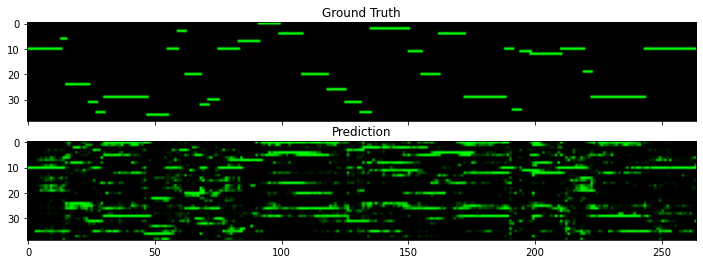

epoch 15: 100%|██████████| 4158/4158 [00:15<00:00, 269.35it/s, loss=  1.033]
2022-05-17 19:01:58.764 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.741 Accuracy: 60.5% Precision: 60.5% Recall: 0.605 F1: 0.605


Wav File: DR8_MRLK0_SX213.WAV Accuracy: 41.51%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 19, 25, 25, 25, 31, 31, 31, 31, 31, 30, 30, 30, 
30, 30, 30, 30, 30, 30, 30, 30, 22, 22, 22, 22, 22,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 
 5, 23, 23, 23, 23, 23, 23, 31, 31, 31, 31, 31, 31, 36, 36, 36, 36, 36, 36, 36, 36, 20, 20, 20, 20, 
20, 20, 20, 20, 20, 20, 28, 28, 28, 28, 28, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 16, 
16, 16, 16, 32, 32, 25, 25, 25, 25, 25, 10, 10, 10, 10, 10, 10, 34, 34, 34,  4,  4,  4,  4,  4,  4, 
 5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10, 10, 23, 23, 23, 16, 16, 16, 16, 16, 16, 16, 
16, 16, 16, 31, 31, 31, 25, 25, 25, 11, 11, 11, 11, 11, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 
26, 26, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35, 35, 35, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 26, 26, 31

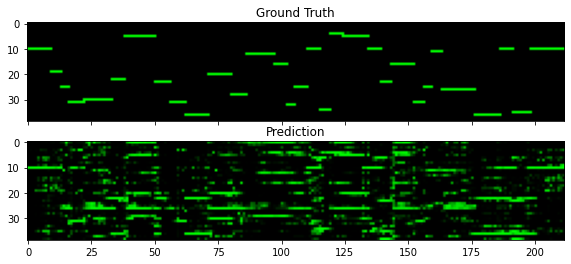

epoch 16: 100%|██████████| 4158/4158 [00:15<00:00, 276.61it/s, loss=  1.013]
2022-05-17 19:02:14.873 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.787 Accuracy: 60.5% Precision: 60.5% Recall: 0.605 F1: 0.605


Wav File: DR2_MMGK0_SX332.WAV Accuracy: 56.25%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35,  8,  8,  8,  8,  8,  8,  8,  8, 
 8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17, 17, 11, 11, 11, 11,  5,  5,  5,  5, 
 5,  5,  5,  5, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 35, 35,  8,  8,  8,  8,  8, 
 8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 17, 17, 17,  4,  4,  4,  4,  4,  4, 12, 12, 12, 12, 
12, 12,  8,  8,  8,  8,  8,  8,  8,  8,  8, 16, 16, 16, 16, 16, 32, 32, 20, 20, 20, 20, 20, 20, 20, 
26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 34,  0,  0,  0,  0,  0, 32, 32, 26, 26, 26, 26, 26, 
27, 26, 26, 26, 26, 26, 26, 22, 22, 22, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9, 12, 
12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 26, 26, 26, 
26, 26, 26, 26, 10, 10, 10, 10,  7,  7, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 35, 35, 35, 35, 35, 
10, 10, 10, 10, 10, 10, 10, 10

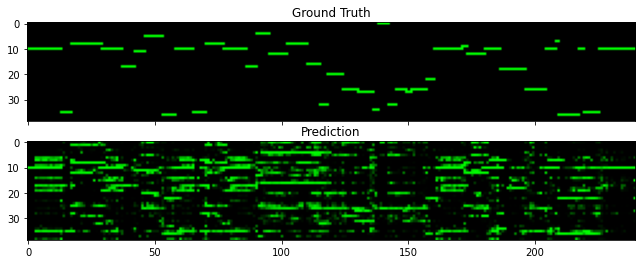

epoch 17: 100%|██████████| 4158/4158 [00:15<00:00, 266.04it/s, loss=  0.992]
2022-05-17 19:02:31.578 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.819 Accuracy: 60.3% Precision: 60.3% Recall: 0.603 F1: 0.603


Wav File: DR6_MPGR1_SA1.WAV Accuracy: 65.13%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33, 
33, 33, 20, 20, 20, 20, 20, 20, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 
10, 10, 10, 10, 21, 21, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 10,  6,  6,  6,  8, 
 8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4,  4,  4, 10, 10, 10, 10, 10,  7,  7,  7,  7, 36, 36, 36, 
36, 36, 36, 36, 36, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 31, 31, 31, 31, 31, 31, 31, 31, 31, 10, 10, 10, 10, 10, 34, 34, 34,  4,  4,  4,  4,  4, 
20, 20, 20, 20, 20, 20, 20, 36, 36, 36, 36, 36, 36, 36, 36, 36, 26, 26, 26, 26, 26, 26, 26, 13, 13, 
13, 13, 13, 13, 13, 13, 13,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 33, 33, 33, 
33, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 25, 25, 25, 25, 25, 25, 32, 32, 32, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 

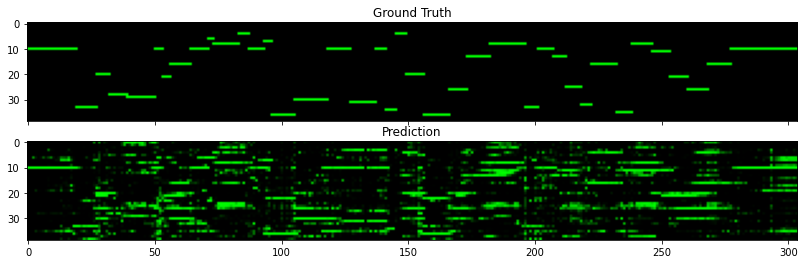

epoch 18: 100%|██████████| 4158/4158 [00:14<00:00, 286.46it/s, loss=  0.974]
2022-05-17 19:02:47.174 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.813 Accuracy: 60.1% Precision: 60.1% Recall: 0.601 F1: 0.601


Wav File: DR3_FEME0_SI2135.WAV Accuracy: 54.85%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 21, 21, 21, 30, 30, 30, 30, 30, 
18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 11, 11, 11, 
11, 11, 11, 11, 28, 28, 28, 28, 26, 26, 26, 26, 26, 26, 26, 26, 26,  3,  3,  3,  3,  3,  3,  3,  3, 
 3, 35, 35, 35, 35, 35, 35,  0,  0,  0,  0,  0,  0,  0,  0, 15, 15, 15,  4,  4,  4,  4,  4, 20, 20, 
20, 20, 20, 20,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 
12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 18, 18, 18, 18, 18, 18, 18, 18, 18, 
18, 18, 18, 18, 18, 18, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 19, 19, 19, 19, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 25, 25, 25, 25, 25, 25, 25, 13, 13, 13, 13, 13, 13, 13, 13,  5, 
 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 1

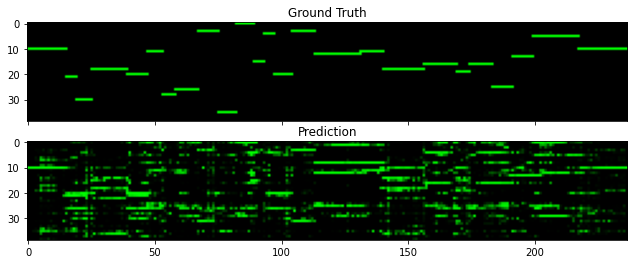

epoch 19: 100%|██████████| 4158/4158 [00:16<00:00, 251.54it/s, loss=  0.956]
2022-05-17 19:03:04.750 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.885 Accuracy: 59.2% Precision: 59.2% Recall: 0.592 F1: 0.592


Wav File: DR2_FAJW0_SX3.WAV Accuracy: 65.52%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 26, 26, 26, 26, 26, 26, 26, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 13, 13, 13, 25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 22, 
22, 22, 22, 35, 35, 35, 35, 35, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 22, 
22, 22, 22, 22, 22, 22, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 18, 18, 18, 18, 18, 18, 18, 18, 
18, 18, 18,  8,  8,  8,  8,  8,  8,  8,  8,  4,  4,  4, 35, 35, 35, 35, 35, 35, 25, 25, 25, 25, 25, 
25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 36, 36, 36, 36, 36, 36, 36, 36, 36, 
36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
Prediction:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 19, 26, 26, 26, 24, 30, 26, 36, 36, 22, 36, 
36, 36, 36, 36, 36, 36, 36, 10, 10, 18, 35,  3, 11, 13, 30, 30, 37, 25, 22, 22, 36, 22, 36, 22, 36, 
36, 36, 22, 20, 10, 10, 

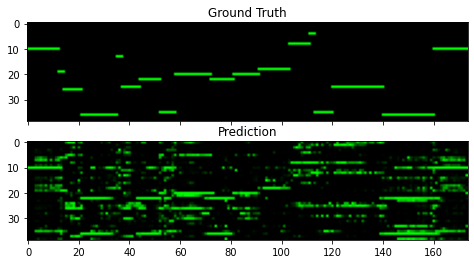

In [16]:
model = Segmentor(cfg).cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

if os.path.exists(cfg.ckpt_path) and cfg.re_train:
    model.load_state_dict(torch.load(cfg.ckpt_path))
    logger.info('Model loaded from checkpoint.')
else:
    logger.info('Model initiated.')

logger.info('Training started.')
print('----------------------------')
results = []
for epoch in range(cfg.epochs):
    train_loss = train_loop(epoch, train_dataloader, model, loss, optimizer)
    val_loss, val_acc, val_pre, val_recall, val_f1 = validate(val_dataloader, model, loss)
    results.append([epoch, train_loss, val_loss, val_acc, val_pre, val_recall, val_f1])

if not cfg.dev_run:
    with open(cfg.report_path, 'w', encoding='utf-8') as fw:
        fw.writelines([','.join([str(i) for i in result]) + '\n' for result in results])
    torch.save(model.state_dict(), cfg.ckpt_path)

### Test

#### Load test data

In [ ]:
test_dataset = TimitDataset.get_test_dataset(cfg.dataset_path, cfg)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_pad)

#### Run test

2022-05-17 19:03:43.697 | INFO     | __main__:<module>:6 - Model loaded from checkpoint.
2022-05-17 19:03:44.790 | INFO     | __main__:validate:63 - Val Result: Avg loss:   1.885 Accuracy: 59.2% Precision: 59.2% Recall: 0.592 F1: 0.592


Wav File: DR5_FLMK0_SX135.WAV Accuracy: 56.10%
Ground Truth:
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 35, 35, 
 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 26, 26, 26, 26, 10,  7, 
 7,  7,  7,  7,  7,  7,  7,  7,  7, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  4,  4,  4, 
 4,  4,  4,  4,  4,  4,  4,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 10,  6,  6, 16, 16, 16, 16, 
16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 
10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7,  7,  7,  7,  7,  7, 26, 26, 
26, 26, 26, 26, 26, 31, 31, 31, 25, 25, 25, 25, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  4, 
 4,  4,  4,  4,  4,  4,  4, 20, 20, 20, 20, 20, 20, 20, 20, 15, 15, 15, 15, 15, 15, 21, 21, 21, 21, 
21,  5,  5,  5,  5,  5,  5,  5

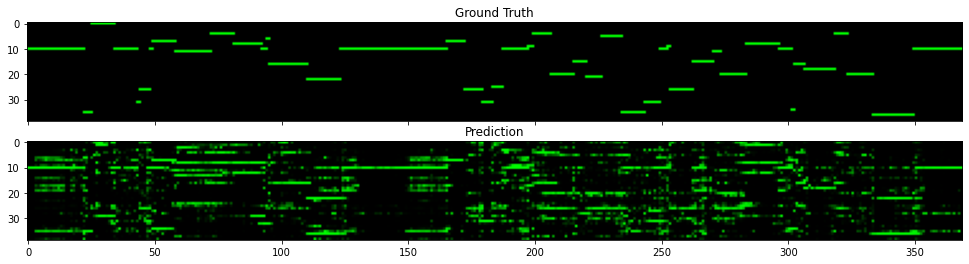

In [17]:
model = Segmentor(cfg).cuda()
if not os.path.exists(cfg.ckpt_path):
    logger.error('No available checkpoint file found, exiting ...')
else:
    model.load_state_dict(torch.load(cfg.ckpt_path))
    logger.info('Model loaded from checkpoint.')

    validate(test_dataloader, model, loss)